#Environment (Run)

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
!pip install transformers
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.4 MB/s 
     |████████████████████████████████| 101 kB 11.3 MB/s 
     |████████████████████████████████| 6.6 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 26.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Gen RAM Free: 12.2 GB  | Proc size: 95.6 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
#import library
import numpy as np
import pandas as pd

In [ ]:
#import torch and check cuda
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#Dataset

In [ ]:
# Upload data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
traindata = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/Preprocessing/random oversampling result/Preprocess Oversampling random over majority class Tweet Result Emotion Biner Januari 2022.xlsx')
traindata.shape

(806, 16)

In [ ]:
# traindata_emotionbiner = traindata[['text_reply', 'Emotion Reply Biner']]
# traindata_emotionbiner = traindata_emotionbiner.loc[traindata_emotionbiner['text_reply'].notnull()]
# traindata_emotionbiner['Emotion Reply Biner'] = traindata_emotionbiner['Emotion Reply Biner'].replace(-1, 2)

traindata_emotionbiner = traindata[['tweet', 'Emotion Tweet Biner']]
traindata_emotionbiner = traindata_emotionbiner.loc[traindata_emotionbiner['tweet'].notnull()]
traindata_emotionbiner['Emotion Tweet Biner'] = traindata_emotionbiner['Emotion Tweet Biner'].replace(-1, 2)

In [ ]:
print(traindata_emotionbiner.shape)
print(traindata_emotionbiner.isnull().sum())
# print(traindata_emotionbiner['Emotion Reply Biner'].value_counts())
print(traindata_emotionbiner['Emotion Tweet Biner'].value_counts())

(805, 2)
tweet                  0
Emotion Tweet Biner    0
dtype: int64
Emotion    403
Neutral    402
Name: Emotion Tweet Biner, dtype: int64


In [ ]:
testdata = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/Preprocessing/Preprocessing for oversampling/Preprocessing Result for Oversampling random over majority class Februari 2022.xlsx")

In [ ]:
# testdata = testdata.loc[testdata['text_reply'].notnull()]
testdata = testdata.loc[testdata['tweet'].notnull()]
print(testdata.isnull().sum())

username           0
id_tweet_ori       0
date               0
time               0
replies_count      0
likes_count        0
retweet_count      0
tweet              0
text_reply       140
dtype: int64


In [ ]:
# print(traindata_sentiment.shape,testdata.shape)
# print(traindata_sentiment.isnull().sum())
# print(testdata_sentiment.isnull().sum())

#BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1", do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# sentences = traindata_emotionbiner['text_reply'].values

# mapping = { 'Neutral':'0', 'Emotion':'1'}
# for k, v in mapping.items():
#     traindata_emotionbiner['Emotion Reply Biner'] = traindata_emotionbiner['Emotion Reply Biner'].replace(k, v)

# labels = traindata_emotionbiner['Emotion Reply Biner'].astype(int).values

sentences = traindata_emotionbiner['tweet'].values

mapping = { 'Neutral':'0', 'Emotion':'1'}
for k, v in mapping.items():
    traindata_emotionbiner['Emotion Tweet Biner'] = traindata_emotionbiner['Emotion Tweet Biner'].replace(k, v)

labels = traindata_emotionbiner['Emotion Tweet Biner'].astype(int).values

In [ ]:
# test_sentences = testdata['text_reply'].values
test_sentences = testdata['tweet'].values

In [ ]:
import statistics
sent_length = []

# Untuk setiap kalimat
for sent in sentences:
    # Tokenisasi teks dan tambah token `[CLS]` dan `[SEP]`
    token_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(token_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  28.185093167701865
Median length =  26


In [ ]:
# Tokenisasi semua kalimat dan map token ke bentuk word id
token_ids = []
attention_masks = []


for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Kalimat yang diencode
                        add_special_tokens = True, # Penambahan '[CLS]' dan '[SEP]'
                        max_length = 100,           # Pad dan truncate semua kalimat jadi 100
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Buat attetion mask (pembeda kalimat dan padding)
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    token_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Ubah list token ids dan attention mask menjadi tensor
input_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# labels = torch.nn.functional.one_hot(labels.to(torch.int64))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Print kalimat dengan index 0
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention Masks:', attention_masks[0])

Original:  orang tua begitu ketakutan saat anaknya demam padahal demam merupakan mekanisme alami tubuh melawan infeksi
Token IDs: tensor([   2,  232, 1594,  975, 8231,  305, 4097, 6567, 2234, 6567,  407, 5921,
        1798,  825, 3424, 3406,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

#Training and Validation Data Preparation (Don't Run it)

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Gabungkan setiap token (input training) menjadi TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Bagi data 80-20 train-validation split.
# Hitung jumlah sampel pada masing-masing split size
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Bagi secara random data untuk train dan val tanpa ada yang tumpang tindih
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  644 training samples
  161 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Set batch_size 32 https://link.springer.com/article/10.1007/s10660-022-09560-w
''' BERT authors recommend the hyperparameters used for fine-tuning [22]. 
For training and validation of classifiers developed with sequence lengths of 64, 128, 256, and 320,
 a batch size of 32 is used. For fine-tuning BERT, the authors recommend batch sizes of 16 and 32 '''
batch_size = 32

# Buat DataLoader untuk train dan val set untuk mengatur batching dan sampling
# Training sample diambil urutannya secara acak (agar dalam satu batch diharapkan sample bervariasi)
train_dataloader = DataLoader(
            train_dataset,  # The training samples
            sampler = RandomSampler(train_dataset), # Pilih sample batch secara random
            batch_size = batch_size # Train dengan jumlah batch size 32
        )

# Validation sample diambil secara berurutan (karena urutan sudah tidak penting lagi)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pilih sample batch secara sequential (urut)
            batch_size = batch_size # Evaluasi dengan jumlah batch size 32
        )

#Training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel
# Load BertForSequenceClassification: the pretrained BERT model with single linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels = 2, #jumlah label
    output_attentions = False, # tidak return attentions weights
    output_hidden_states = False, # tidak returns all hidden-states
)

# Run model di GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

learning rate dan epsilon mengikuti eksperimen penelitian lalu
https://docs.google.com/document/d/1BFZQx3uELgcoDQVa8sMNKhbAaMXtx3Vjb2DZ6Uayci4/edit

In [ ]:
from transformers import AdamW

#AdamW optimizer dengan weight decay untuk menurunkan kemungkinan overfitting
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

* Hasil split training samples = 644
* Batch size = 32
* Jumlah batch = 644/32 -> 21
* Training steps (total steps) = 21 (jumlah batch) * 10 (epoch) = 210 per epoch

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total jumlah training steps = [Jumlah batch] x [Jumlah epochs]
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Warmup explanation https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning,
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup
# num_warmup_steps default 0
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Jumlah batch : 21


## Training Loop

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import numpy as np

# Hitung akurasi prediksi vs label
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
y_true_val=[]
y_pred_val = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
  train_accuracy = 0
  model.train()

  # Untuk setiap batch
  for step, batch in enumerate(train_dataloader):
    
    # Progress update setiap 10 batches
    if step % 10 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]
    pred = outputs[1]
    pred = pred.detach().cpu().numpy()
    total_loss += loss.item()

    loss.backward()
    label_ids = b_labels.to('cpu').numpy()

    tmp_train_accuracy = flat_accuracy(pred, label_ids)

    train_accuracy += tmp_train_accuracy

    step += 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Accuracy: {0:.2f}".format(train_accuracy/step))
  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
    if epoch_i==9:
      y_pred_val.append(logits)
      y_true_val.append(label_ids)
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    10 of    21.     Elapsed: 0:00:03
Batch    20 of    21.     Elapsed: 0:00:06
   Accuracy: 0.66
   Average training loss: 0.61
   Training epoch took: 0:00:06
Running Validation...
   Accuracy: 0.83
   Validation took: 0:00:01
======= Epoch 2 / 10 =======
Training...
Batch    10 of    21.     Elapsed: 0:00:03
Batch    20 of    21.     Elapsed: 0:00:06
   Accuracy: 0.86
   Average training loss: 0.38
   Training epoch took: 0:00:06
Running Validation...
   Accuracy: 0.88
   Validation took: 0:00:00
======= Epoch 3 / 10 =======
Training...
Batch    10 of    21.     Elapsed: 0:00:03
Batch    20 of    21.     Elapsed: 0:00:06
   Accuracy: 0.94
   Average training loss: 0.18
   Training epoch took: 0:00:06
Running Validation...
   Accuracy: 0.92
   Validation took: 0:00:00
======= Epoch 4 / 10 =======
Training...
Batch    10 of    21.     Elapsed: 0:00:03
Batch    20 of    21.     Elapsed: 0:00:06
   Accuracy: 0.98
   Average training loss: 0

## Performance Evaluation (Don't Run It)

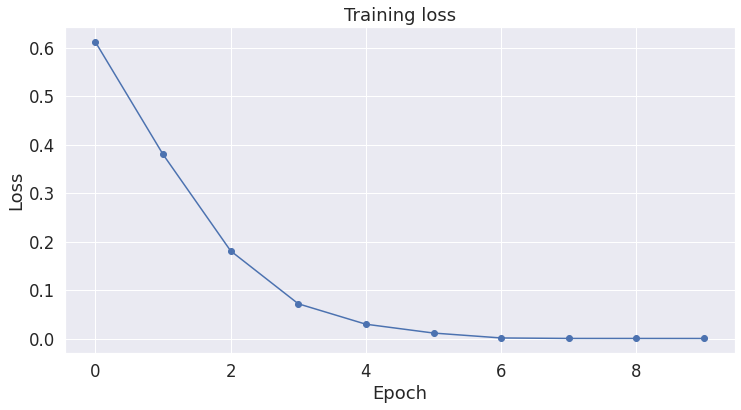

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import sklearn.metrics as skm
import numpy as np

y_pred_val = np.concatenate(y_pred_val, axis=0)
y_pred_val = np.argmax(y_pred_val, axis=1).flatten()


y_true_val = np.concatenate(y_true_val, axis=0)
# y_true_val = np.argmax(y_true_val, axis=1).flatten()


print(len(y_pred_val))
print(len(y_true_val))

161
161


In [ ]:
cm = skm.multilabel_confusion_matrix(y_true_val, y_pred_val)
print(cm)
print(skm.classification_report(y_true_val, y_pred_val))

[[[79 11]
  [ 8 63]]

 [[63  8]
  [11 79]]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        71
           1       0.91      0.88      0.89        90

    accuracy                           0.88       161
   macro avg       0.88      0.88      0.88       161
weighted avg       0.88      0.88      0.88       161



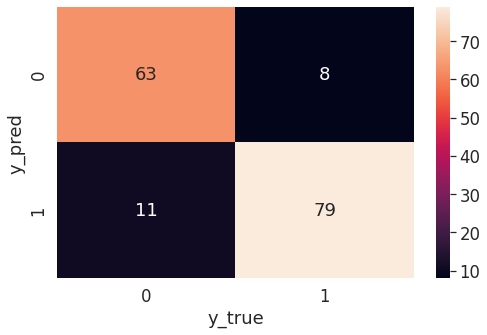

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true_val, y_pred_val), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.show()

# Predict

In [ ]:
token_ids = []
attention_masks = []

for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                
                        add_special_tokens = True
                        max_length = 256,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',   
                        padding = 'max_length',
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

 
batch_size = 1


prediction_data = TensorDataset(token_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 7783


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(token_ids)))

# Ubah model jadi mode evaluasi
model.eval()

predictions = []

for batch in prediction_dataloader:
  # Tambah batch ke GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack inputs dari dataloader
  b_input_ids, b_input_mask = batch
  
  # Untuk prediksi gradien tidak dihitung atau disimpan (autograd dimatikan) untuk saving memory dan mempercepat prediksi
  with torch.no_grad():
      # Hitung logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Pindah logits dan label ke CPU
  logits = logits.detach().cpu().numpy()
  
  # Simpan prediksi
  predictions.append(logits)

print('    DONE.')

Predicting labels for 7,783 test sentences...
    DONE.


In [ ]:
predictions

[array([[ 4.510354 , -5.2009673]], dtype=float32),
 array([[-4.014301 ,  3.9680057]], dtype=float32),
 array([[ 3.761116, -4.301544]], dtype=float32),
 array([[ 3.5091953, -4.111914 ]], dtype=float32),
 array([[ 4.1792636, -4.8664155]], dtype=float32),
 array([[-3.2197886,  3.454821 ]], dtype=float32),
 array([[ 2.928134 , -3.7806015]], dtype=float32),
 array([[ 4.690763, -5.12462 ]], dtype=float32),
 array([[-4.031798,  4.334394]], dtype=float32),
 array([[ 4.5097947, -5.067922 ]], dtype=float32),
 array([[ 2.7403347, -3.3442302]], dtype=float32),
 array([[-0.50049686,  1.0727047 ]], dtype=float32),
 array([[ 4.6667275, -5.1311917]], dtype=float32),
 array([[-4.692286 ,  4.7270756]], dtype=float32),
 array([[-4.70417 ,  5.055892]], dtype=float32),
 array([[ 2.024224 , -2.3723392]], dtype=float32),
 array([[ 3.521351, -3.908943]], dtype=float32),
 array([[-3.2539635,  3.26668  ]], dtype=float32),
 array([[-4.5209503,  4.7800674]], dtype=float32),
 array([[ 3.936596, -4.546154]], dtype=

In [ ]:
np.shape(predictions)

(7783, 1, 2)

In [ ]:
predictions = np.concatenate(predictions, axis=0)

In [ ]:
data_result = pd.DataFrame(predictions, columns=['EMOTION BINER REPLY NEUTRAL', 'EMOTION BINER REPLY EMOTION'])

In [ ]:
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict

,EMOTION BINER REPLY NEUTRAL,EMOTION BINER REPLY EMOTION
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
7778,1,0
7779,1,0
7780,1,0
7781,1,0


In [ ]:
print(testdata.shape)
print(dfhasilpredict.shape)

(7783, 9)
(7783, 2)


In [ ]:
finalresult = pd.concat([testdata.reset_index(), dfhasilpredict.reset_index()], axis=1, sort=False)
finalresult = finalresult.drop('index', axis=1)
finalresult

,username,id_tweet_ori,date,time,replies_count,likes_count,retweet_count,tweet,text_reply,EMOTION BINER REPLY NEUTRAL,EMOTION BINER REPLY EMOTION
0,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10,265,71,titip salam ke guru kamu bahwa covid19 itu pen...,karena dalam islam diajarkan ketika kamu perca...,1,0
1,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10,265,71,titip salam ke guru kamu bahwa covid19 itu pen...,saya kebetulan juga guru agama ners eh tapi sa...,0,1
2,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10,265,71,titip salam ke guru kamu bahwa covid19 itu pen...,ada juga yang aneh masih keluarga ku capek ban...,1,0
3,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10,265,71,titip salam ke guru kamu bahwa covid19 itu pen...,orang kayak begini meski sudah kena juga akan ...,1,0
4,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10,265,71,titip salam ke guru kamu bahwa covid19 itu pen...,berbisnis yang tidak mementingkan kesehatan da...,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7778,mbahndi,1.494559e+18,2022-02-18,06:27:00+00:00,2,64,22,banyak pasien muda antara usia 2025 tahun yang...,kalau saya biasanya karena takut terhadap sesu...,1,0
7779,mbahndi,1.494559e+18,2022-02-18,06:27:00+00:00,2,64,22,banyak pasien muda antara usia 2025 tahun yang...,mungkin yang tidak tahu penyebabnya makin kura...,1,0
7780,mbahndi,1.494522e+18,2022-02-18,04:01:21+00:00,2,7,0,dua belas tahun yang lalu saya menulis notes i...,namanya juga usaha berdoa cengiran,1,0
7781,mbahndi,1.494522e+18,2022-02-18,04:01:21+00:00,2,7,0,dua belas tahun yang lalu saya menulis notes i...,masih awal tahun 2010 saya masih 3 sama belum ...,1,0


In [ ]:
from google.colab import files
finalresult.to_excel('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/result/Predict Result Emotion Biner Reply Oversampling major class Februari 2022.xlsx', index=False) 

#Save Model

In [ ]:
filepath = '/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/indobertindobenchmarkemotionbinertweet.pth'
torch.save(model, filepath)